<a href="https://colab.research.google.com/github/andrewzlee/prosper-investing/blob/master/portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prosper Loan Optimal Selection Strategy


### Assumptions
1.   Assume only 1 year timeframe. Not realistic
2.   Assume defaults returns a 50% loss.





# Step 0: Setup space, High level Default Exploration

In [1]:
#%pip install -U sklearn

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/prosper-investing'

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
#https://stackoverflow.com/questions/62832445/is-it-okay-to-build-a-model-on-imbalanced-data
dat_full_balanced = pd.read_pickle(path + "/data/modeling_data.pkl")
dat_full = pd.read_pickle(path + "/data/modeling_data_imbalanced.pkl")

In [5]:
len(dat_full)

419249

We see here that balanced data changes the actual distribution of defaults compared to the natural state. While this may help the model learn defaults, there is unfair pressure on the lowest Fico Ranges. For example, the $0.0$ and $0.1$ both have a 100% default rate.

In [6]:
agg_data_balanced = pd.concat([dat_full_balanced[dat_full_balanced['loan_status'] == 1].groupby("TUFicoRange").sum()[["loan_status"]],
          dat_full_balanced.groupby("TUFicoRange").count()["occupation"].rename("total")],
          ignore_index=False, axis = 1)
agg_data_balanced

,loan_status,total
TUFicoRange,,
0.0,1299,1299
1.0,1831,1831
2.0,10790,18370
3.0,16037,28449
4.0,16591,31032
5.0,14593,29369
6.0,10005,22608
7.0,5837,14691
8.0,3091,8802


In [7]:
agg_data_balanced["loan_status"]/agg_data_balanced["total"]

TUFicoRange
0.0     1.000000
1.0     1.000000
2.0     0.587371
3.0     0.563710
4.0     0.534642
5.0     0.496884
6.0     0.442542
7.0     0.397318
8.0     0.351170
9.0     0.292725
10.0    0.216495
11.0    0.206612
dtype: float64

Unbalanced dataset shows a much more realistic view of default at each Fico range.

In [8]:
agg_data = pd.concat([dat_full[dat_full['loan_status'] == 1].groupby("TUFicoRange").sum()[["loan_status"]],
          dat_full.groupby("TUFicoRange").count()["occupation"].rename("total")],
          ignore_index=False, axis = 1)
agg_data

<ipython-input-8-85b106b6b084>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_data = pd.concat([dat_full[dat_full['loan_status'] == 1].groupby("TUFicoRange").sum()[["loan_status"]],


,loan_status,total
TUFicoRange,,
640-659,7404,36200
660-679,11629,58734
680-699,12387,68889
700-719,11097,71366
720-739,7855,59037
740-759,4525,41761
760-779,2479,27018
780-799,1348,19129
800-819,546,11107


In [9]:
agg_data["loan_status"]/agg_data["total"]

TUFicoRange
640-659    0.204530
660-679    0.197994
680-699    0.179811
700-719    0.155494
720-739    0.133052
740-759    0.108355
760-779    0.091754
780-799    0.070469
800-819    0.049158
820-850    0.048650
dtype: float64

In [10]:
# Categorize variables

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(dat_full)

dat_categorical = dat_full[categorical_columns]

encoder = OrdinalEncoder().set_output(transform="pandas")
dat_encoded = encoder.fit_transform(dat_categorical)
dat_encoded[:10]

dat_full = dat_full.drop(dat_categorical, axis = 1).join(dat_encoded)

In [11]:
#Split the data into training and test
dat_full = dat_full.dropna()

x = dat_full.drop("loan_status",axis=1)
y = dat_full["loan_status"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=123)

# Step 1: Model Random Forest

In [12]:
rf_clf = RandomForestClassifier(n_estimators = 500, random_state = 123)
rf_clf.fit(x_train,y_train)

RandomForestClassifier(n_estimators=500, random_state=123)

Despite a large training set, recall is poor at a 50% threshold. Therefore we lower the threshold down to 15% to capture defaults.

Note however, this report is not entirely necessary for the next steps.

In [13]:
#clf_report = classification_report(y_test,rf_clf.predict(x_test))
clf_report = classification_report(y_test,(rf_clf.predict_proba(x_test)[:,1] >= .15).astype(int))

print("classification report\n",clf_report)

y_pred_test_rfc = rf_clf.predict_proba(x_test)

classification report
               precision    recall  f1-score   support

           0       0.92      0.57      0.70     71578
           1       0.22      0.71      0.33     11945

    accuracy                           0.59     83523
   macro avg       0.57      0.64      0.52     83523
weighted avg       0.82      0.59      0.65     83523



(array([7.010e+02, 9.890e+02, 1.183e+03, 1.269e+03, 1.377e+03, 2.064e+03,
        1.634e+03, 1.737e+03, 1.831e+03, 1.872e+03, 2.631e+03, 2.006e+03,
        2.106e+03, 2.115e+03, 2.150e+03, 2.754e+03, 2.135e+03, 2.081e+03,
        2.114e+03, 2.059e+03, 2.031e+03, 2.639e+03, 1.987e+03, 1.865e+03,
        1.838e+03, 1.731e+03, 2.243e+03, 1.713e+03, 1.656e+03, 1.535e+03,
        1.501e+03, 1.924e+03, 1.372e+03, 1.365e+03, 1.255e+03, 1.203e+03,
        1.567e+03, 1.112e+03, 1.076e+03, 1.036e+03, 9.950e+02, 8.850e+02,
        1.228e+03, 8.510e+02, 8.330e+02, 7.460e+02, 7.460e+02, 8.600e+02,
        6.770e+02, 6.310e+02, 5.520e+02, 5.170e+02, 6.510e+02, 4.190e+02,
        4.030e+02, 3.690e+02, 3.410e+02, 3.970e+02, 2.490e+02, 2.430e+02,
        1.900e+02, 1.800e+02, 1.650e+02, 2.150e+02, 1.440e+02, 8.700e+01,
        1.150e+02, 6.500e+01, 7.800e+01, 4.700e+01, 3.500e+01, 3.600e+01,
        2.400e+01, 2.800e+01, 1.800e+01, 9.000e+00, 4.000e+00, 1.200e+01,
        4.000e+00, 2.000e+00, 6.000e+0

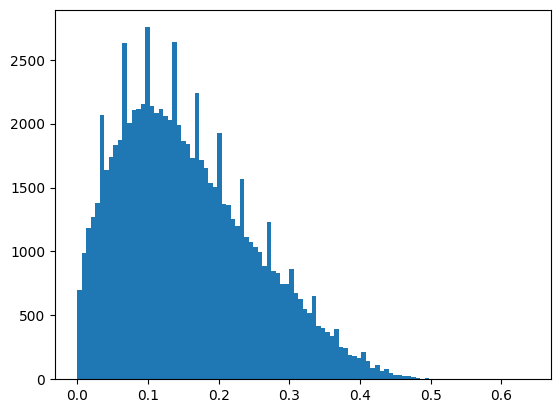

In [14]:
plt.hist(y_pred_test_rfc[:,1], bins = 100)

# Step 2: Portfolio Optimization
Using the probabilities produced by the RF, we will compute an expected return and build strategies around them. We will compare these strategies against more human-picked strategies. Further, we will look at some Naive strategies and compare our performance to a perfect knowledge porfolio.

In [16]:
# Create the final table of expected returns and the actual loan_status.
threshold = 0.15
test_data = pd.concat([x_test.reset_index(drop=True),
                       y_test.reset_index(drop=True),
                       pd.DataFrame(y_pred_test_rfc[:,1], columns = ["pred_prob"]),
                       pd.DataFrame((rf_clf.predict_proba(x_test)[:,1] >= threshold).astype(int), columns = ["pred_thresh"]),
                       rf_clf.predict_proba(x_test)[:,0] * x_test["lender_yield"].rename("expected_return").reset_index(drop=True),
                       ],
                       ignore_index=False, axis = 1)

In [17]:
test_data.sort_values(by = "expected_return", axis = 0, ascending = False).head(20)[["TUFicoRange","lender_yield","loan_status","pred_prob","pred_thresh","expected_return"]]

,TUFicoRange,lender_yield,loan_status,pred_prob,pred_thresh,expected_return
8273,1.0,0.3082,0,0.056,0,0.290941
73702,2.0,0.3074,0,0.062,0,0.288341
23937,1.0,0.3082,1,0.066,0,0.287859
76676,2.0,0.3082,0,0.076,0,0.284777
18992,0.0,0.3082,0,0.076,0,0.284777
33613,3.0,0.3082,0,0.076,0,0.284777
3462,2.0,0.3082,0,0.080,0,0.283544
23785,4.0,0.3074,0,0.078,0,0.283423
70159,1.0,0.3029,0,0.068,0,0.282303
66264,1.0,0.3082,0,0.088,0,0.281078


In [28]:
# A function to evaluate a selected porfolio and return it's performance
def modelPerformance(num_invested, principal, portfolio, total_return):
  print("Total Invested: " + str(num_invested) + " Num Defaulted: " + str(sum(portfolio["loan_status"])) + " Pct Default: " + str(round(sum(portfolio["loan_status"]/num_invested), 4) ))
  print("Average Expected Return: " + str(round(portfolio["expected_return"].mean(), 4) ))
  print("Return: $" + str(round(total_return - (principal*num_invested),4) ))
  print("ROI: " + str(round(total_return/(principal*num_invested),4) ))

## Basic Strategy
Select random number of loans from each FICO group based on a human-picked distribution.

In [41]:
distr = {"0.0": 0.0, "1.0": 0.00, "2.0": 0.05, "3.0": 0.10, "4.0": 0.10, "5.0": 0.15,
         "6.0": 0.20, "7.0": 0.15, "8.0": 0.15, "9.0": 0.10, "10.0": 0.00, "11.0": 0.00 }

# distr = {"0.0": 0.0, "1.0": 0.00, "2.0": 0.00, "3.0": 0.00, "4.0": 0.00, "5.0": 0.00,
#          "6.0": 0.00, "7.0": 0.00, "8.0": 0.00, "9.0": 0.00, "10.0": 0.0, "11.0": 1 }
principal = 25
num_invested = 200

distr_loans = {k: v*num_invested for k, v in distr.items()}

portfolio = pd.DataFrame()

for d in distr:
  test_subset = test_data[test_data["TUFicoRange"] == int(float(d))] # Select all rows for a given Fico
  if int(distr_loans[d]) > 0 and len(test_subset) > 0:
    test_subset = test_subset.sample(n = int(distr_loans[d]), replace = False, ignore_index = False, random_state = 123)
    portfolio = pd.concat([portfolio, test_subset], ignore_index = True)

print(len(portfolio))

200


In [42]:
principal = 25

total_return = sum(principal * portfolio.apply(lambda row: 0.5 if row["loan_status"] == 1 else 1 + row["lender_yield"], axis = 1))

modelPerformance(num_invested, principal, portfolio, total_return)

Total Invested: 200 Num Defaulted: 13 Pct Default: 0.065
Average Expected Return: 0.0799
Return: $255.0375
ROI: 1.051


## Highest Returns
Select all the loans with the highest yield in a greedy approach.

In [34]:
# Highest returns
principal = 25
num_invested = 200
portfolio = test_data.sort_values(by = "lender_yield", axis = 0, ascending = False).head(num_invested)[["TUFicoRange","lender_yield","loan_status","pred_prob","pred_thresh","expected_return"]]

total_return = sum(principal * portfolio.apply(lambda row: 0.5 if row["loan_status"] == 1 else 1 + row["lender_yield"], axis = 1))

modelPerformance(num_invested, principal, portfolio, total_return)

Total Invested: 200 Num Defaulted: 56 Pct Default: 0.28
Average Expected Return: 0.2184
Return: $409.52
ROI: 1.0819


## Perfect Strategy
Select all the loans with the highest yield like previously. However, we assume there are no defaults. This is close to only picking non-defaults, but slightly higher ROI.

In [35]:
#Perfect Strategy, no defaults
principal = 25
num_invested = 200
portfolio = test_data.sort_values(by = "lender_yield", axis = 0, ascending = False).head(num_invested)[["TUFicoRange","lender_yield","loan_status","pred_prob","pred_thresh","expected_return"]]

total_return = sum(principal * portfolio.apply(lambda row: 1 + row["lender_yield"] if row["loan_status"] == 1 else 1 + row["lender_yield"], axis = 1))

modelPerformance(num_invested, principal, portfolio, total_return)

Total Invested: 200 Num Defaulted: 56 Pct Default: 0.28
Average Expected Return: 0.2184
Return: $1541.0
ROI: 1.3082


## Optimized Strategy

Highest $E(r)$ Strategies:
1. Compute expected return for all loans and sort by highest return
2. Sort by lowest probability of default

Modified Highest $E(r)$:
1. Define a weighting for every FICO range that punishes lower scores even further.
2. We can also use an optimization algo to find the best weighting that maximizes return. However, the optimizer will need to know defaults ahead of time to calculate. Consequently, we could be introducing immense bias. We can try to backtest.


In [36]:
#(1)
principal = 25
num_invested = 200
portfolio = test_data.sort_values(by = "expected_return", axis = 0, ascending = False).head(num_invested)[["TUFicoRange","lender_yield","loan_status","pred_prob","pred_thresh","expected_return"]]

total_return = sum(principal * portfolio.apply(lambda row: 0.5 if row["loan_status"] == 1 else 1 + row["lender_yield"], axis = 1))

modelPerformance(num_invested, principal, portfolio, total_return)

Total Invested: 200 Num Defaulted: 31 Pct Default: 0.155
Average Expected Return: 0.2649
Return: $898.7775
ROI: 1.1798


In [37]:
#Modifed (1)

distr = {"0.0": 0.60, "1.0": 0.65, "2.0": 0.70, "3.0": 0.75, "4.0": 0.80, "5.0": 0.85,
         "6.0": 0.93, "7.0": 0.95, "8.0": 0.96, "9.0": 0.98, "10.0": 1.0, "11.0": 1.0 }

test_data["updated_return"] = test_data.apply(lambda row: distr[str(row["TUFicoRange"])] * row["expected_return"], axis = 1)

principal = 25
num_invested = 200
portfolio = test_data.sort_values(by = "updated_return", axis = 0, ascending = False).head(num_invested)[["TUFicoRange","lender_yield","loan_status","pred_prob","pred_thresh","expected_return","updated_return"]]

total_return = sum(principal * portfolio.apply(lambda row: 0.5 if row["loan_status"] == 1 else 1 + row["lender_yield"], axis = 1))


modelPerformance(num_invested, principal, portfolio, total_return)


Total Invested: 200 Num Defaulted: 32 Pct Default: 0.16
Average Expected Return: 0.252
Return: $846.3225
ROI: 1.1693


# Step 4: Test code
Uncategorized test code

In [40]:
test_data[test_data["TUFicoRange"] == 0].head(10)

,listing_amount,estimated_return,estimated_loss_rate,lender_yield,effective_yield,borrower_rate,borrower_apr,listing_term,listing_monthly_payment,prosper_score,...,dti_wprosper_loan,prosper_rating,employment_status_description,occupation,TUFicoRange,loan_status,pred_prob,pred_thresh,expected_return,updated_return
13,6000.0,0.0908,0.0539,0.1474,0.1447,0.1574,0.1943,36,210.17,6.0,...,0.247,2.0,0.0,68.0,0.0,0,0.136,0,0.127354,0.076412
39,10000.0,0.1355,0.0824,0.2220,0.2179,0.2320,0.2575,60,283.05,7.0,...,0.163,3.0,0.0,9.0,0.0,0,0.244,1,0.167832,0.100699
56,15000.0,0.1065,0.0689,0.1799,0.1754,0.1899,0.2275,36,549.76,9.0,...,0.130,3.0,0.0,37.0,0.0,1,0.336,1,0.119454,0.071672
66,10000.0,0.0682,0.0524,0.1224,0.1206,0.1324,0.1687,36,338.10,9.0,...,0.220,2.0,0.0,71.0,0.0,0,0.178,1,0.100613,0.060368
81,8000.0,0.0552,0.0224,0.0784,0.0776,0.0884,0.1238,36,253.80,4.0,...,0.170,0.0,0.0,44.0,0.0,0,0.120,0,0.068992,0.041395
93,15000.0,0.0645,0.0464,0.1124,0.1109,0.1224,0.1585,36,499.94,10.0,...,0.270,2.0,0.0,37.0,0.0,0,0.168,1,0.093517,0.056110
94,15000.0,0.0612,0.0474,0.1124,0.1086,0.1224,0.1453,60,335.49,8.0,...,0.180,2.0,0.0,51.0,0.0,0,0.090,0,0.102284,0.061370
102,10000.0,0.0537,0.0249,0.0794,0.0786,0.0894,0.1248,36,317.72,5.0,...,0.100,0.0,0.0,19.0,0.0,0,0.176,1,0.065426,0.039255
106,15000.0,0.0536,0.0399,0.0945,0.0935,0.1045,0.1402,36,487.18,10.0,...,0.220,0.0,0.0,69.0,0.0,1,0.130,0,0.082215,0.049329
116,10000.0,0.1039,0.0824,0.1920,0.1863,0.2020,0.2399,36,372.66,6.0,...,0.240,3.0,0.0,22.0,0.0,1,0.174,1,0.158592,0.095155


In [38]:
agg_data = pd.concat([test_data[test_data['loan_status'] == 1].groupby("TUFicoRange").sum()[["pred_thresh", "loan_status"]],
          test_data.groupby("TUFicoRange").count()["occupation"].rename("total")],
          ignore_index=False, axis = 1)
agg_data

,pred_thresh,loan_status,total
TUFicoRange,,,
0.0,1354,1493,7628
1.0,1984,2334,12387
2.0,1882,2422,14375
3.0,1522,2254,14973
4.0,946,1591,12298
5.0,445,886,8720
6.0,222,512,5807
7.0,107,297,4145
8.0,37,118,2365


These results show that as a person becomes more credit worthy, it becomes much harder to anticipate defaults.

In [39]:
agg_data["pct_default"] = agg_data.apply(lambda row: row["loan_status"]/ row["total"],axis = 1)
agg_data["recall"] = agg_data["pred_thresh"]/agg_data["loan_status"] #agg_data.apply(lambda row: row["pred_thresh"]/ row["loan_status"],axis = 1)
agg_data

,pred_thresh,loan_status,total,pct_default,recall
TUFicoRange,,,,,
0.0,1354,1493,7628,0.195726,0.906899
1.0,1984,2334,12387,0.188423,0.850043
2.0,1882,2422,14375,0.168487,0.777044
3.0,1522,2254,14973,0.150538,0.675244
4.0,946,1591,12298,0.129371,0.594595
5.0,445,886,8720,0.101606,0.502257
6.0,222,512,5807,0.088169,0.433594
7.0,107,297,4145,0.071653,0.360269
8.0,37,118,2365,0.049894,0.313559
